In [ ]:
import pandas as pd
import yfinance as yf

# Load the VADER scores CSV
vader_df = pd.read_csv("average_vader_scores_by_date.csv")
vader_df["Date"] = pd.to_datetime(vader_df["Date"])

# Download NIFTY 50 data
nifty = yf.download("^NSEI",
                    start=vader_df["Date"].min().strftime('%Y-%m-%d'),
                    end=(vader_df["Date"].max() + pd.Timedelta(days=1)).strftime('%Y-%m-%d'))

# Reset the index to make 'Date' a column
nifty.reset_index(inplace=True)

# Flatten column names in case of multi-index
nifty.columns = [col if isinstance(col, str) else col[0] for col in nifty.columns]

# Print to confirm actual column names
print("NIFTY columns:", nifty.columns.tolist())

# Decide which column to use for closing price
if "Close" in nifty.columns:
    price_col = "Close"
elif "Adj Close" in nifty.columns:
    price_col = "Adj Close"
else:
    raise ValueError("No suitable Close price column found in NIFTY data!")

# Create a subset with Date and Close price
nifty_subset = nifty[["Date", price_col]].copy()
nifty_subset.rename(columns={price_col: "NIFTY_50_Close"}, inplace=True)
nifty_subset["Date"] = pd.to_datetime(nifty_subset["Date"])

# Merge with VADER scores
merged_df = pd.merge(vader_df, nifty_subset, on="Date", how="left")

# Save final result
merged_df.to_csv("vader_with_nifty_close.csv", index=False)
print("✅ Saved as vader_with_nifty_close.csv")

[*********************100%***********************]  1 of 1 completed

NIFTY columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
✅ Saved as vader_with_nifty_close.csv


In [ ]:
import pandas as pd
import yfinance as yf

# Load the VADER scores CSV
vader_df = pd.read_csv("average_vader_scores_by_date.csv")
vader_df["Date"] = pd.to_datetime(vader_df["Date"])

# Download NIFTY 50 data
nifty = yf.download("^NSEI",
                    start=vader_df["Date"].min().strftime('%Y-%m-%d'),
                    end=(vader_df["Date"].max() + pd.Timedelta(days=1)).strftime('%Y-%m-%d'))

# Reset index and flatten columns if needed
nifty.reset_index(inplace=True)
nifty.columns = [col if isinstance(col, str) else col[0] for col in nifty.columns]

# Identify close column
if "Close" in nifty.columns:
    price_col = "Close"
elif "Adj Close" in nifty.columns:
    price_col = "Adj Close"
else:
    raise ValueError("No suitable Close price column found!")

# Subset and rename
nifty_subset = nifty[["Date", price_col]].copy()
nifty_subset.rename(columns={price_col: "NIFTY_50_Close"}, inplace=True)
nifty_subset["Date"] = pd.to_datetime(nifty_subset["Date"])

# Merge with VADER scores
merged_df = pd.merge(vader_df, nifty_subset, on="Date", how="left")

# Sort by date to apply rolling averages
merged_df.sort_values("Date", inplace=True)

# Fill missing values using average of previous 3 days (change window size if needed)
merged_df["NIFTY_50_Close"] = merged_df["NIFTY_50_Close"].fillna(
    merged_df["NIFTY_50_Close"].rolling(window=3, min_periods=1).mean()
)

# Save the updated CSV
merged_df.to_csv("vader_with_nifty_close_filled.csv", index=False)
print("✅ Saved as vader_with_nifty_close_filled.csv with missing values filled.")

[*********************100%***********************]  1 of 1 completed

✅ Saved as vader_with_nifty_close_filled.csv with missing values filled.


In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load your file
df = pd.read_csv("cleaned_dates.csv")

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Calculate compound VADER scores
df["vader_score"] = df["Title"].apply(lambda x: analyzer.polarity_scores(str(x))["compound"])

# Convert 'date' column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Group by date and compute average sentiment
avg_scores = df.groupby("Date")["vader_score"].mean().reset_index()

# Save to CSV
avg_scores.to_csv("average_vader_scores_cleaned_dates.csv", index=False)
print("✅ Saved as average_vader_scores_cleaned_dates.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_dates.csv'

In [ ]:
import pandas as pd
import yfinance as yf

# Load VADER scores
vader_df = pd.read_csv("average_vader_scores_cleaned_dates.csv")
vader_df["date"] = pd.to_datetime(vader_df["Date"])

# Download NIFTY 50 data
nifty = yf.download("^NSEI",
                    start=vader_df["date"].min().strftime('%Y-%m-%d'),
                    end=(vader_df["date"].max() + pd.Timedelta(days=1)).strftime('%Y-%m-%d'))

# Reset index so 'Date' becomes a column
nifty.reset_index(inplace=True)

# Flatten MultiIndex if it exists
if isinstance(nifty.columns, pd.MultiIndex):
    nifty.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in nifty.columns]

# Find the actual date column
for col in nifty.columns:
    if "date" in col.lower():
        nifty.rename(columns={col: "date"}, inplace=True)
        break

# Ensure datetime format
nifty["date"] = pd.to_datetime(nifty["date"])

# Print columns to see what we can use
print("Available columns in NIFTY:", nifty.columns.tolist())

# Try to find the best match for closing price
close_candidates = [col for col in nifty.columns if "close" in col.lower()]
if not close_candidates:
    raise ValueError("❌ No 'Close' or 'Adj Close' column found in NIFTY data.")

# Use the first found close-related column
price_col = close_candidates[0]

# Prepare subset
nifty_subset = nifty[["date", price_col]].copy()
nifty_subset.rename(columns={price_col: "NIFTY_50_Close"}, inplace=True)

# Merge and fill missing values using average of previous 3 days
merged_df = pd.merge(vader_df, nifty_subset, on="date", how="left")
merged_df.sort_values("date", inplace=True)
merged_df["NIFTY_50_Close"] = merged_df["NIFTY_50_Close"].fillna(
    merged_df["NIFTY_50_Close"].rolling(window=3, min_periods=1).mean()
)

# Save to CSV
merged_df.to_csv("vader_nifty_cleaned_filled.csv", index=False)
print("✅ Final CSV saved as vader_nifty_cleaned_filled.csv")

[*********************100%***********************]  1 of 1 completed

Available columns in NIFTY: ['date', 'Close_^NSEI', 'High_^NSEI', 'Low_^NSEI', 'Open_^NSEI', 'Volume_^NSEI']
✅ Final CSV saved as vader_nifty_cleaned_filled.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load your data
df = pd.read_csv('vader_nifty_cleaned_filled.csv')

# Preprocess
df = df.drop(columns=['date'])  # Drop redundant date
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['vader_score', 'NIFTY_50_Close']])

# Create sequences
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, 0])  # vader_score
        y.append(data[i+seq_len, 1])    # NIFTY close
    return np.array(X), np.array(y)

seq_len = 10
X, y = create_sequences(scaled, seq_len)
X = X.reshape((X.shape[0], X.shape[1], 1))  # LSTM format

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Predict and inverse scale
predicted = model.predict(X_test)
vader_dummy = np.zeros_like(predicted)
inverse_pred = scaler.inverse_transform(np.hstack([vader_dummy, predicted]))[:, 1]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0383 - val_loss: 0.2531
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0291 - val_loss: 0.2604
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0292 - val_loss: 0.2515
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0307 - val_loss: 0.2179
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0299 - val_loss: 0.2746
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0304 - val_loss: 0.2600
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0299 - val_loss: 0.2417
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0309 - val_loss: 0.2538
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0294 - val_loss: 0.2702
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0305 - val_loss: 0.2605
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0309 - val_loss: 0.2648
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate performance
true = scaler.inverse_transform(np.hstack([vader_dummy, y_test.reshape(-1, 1)]))[:, 1]
mse = mean_squared_error(true, inverse_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true, inverse_pred)
r2 = r2_score(true, inverse_pred)

print(f"📈 RMSE: {rmse:.2f}")
print(f"📉 MAE: {mae:.2f}")
print(f"🧮 R² Score: {r2:.4f}")

📈 RMSE: 10391.23
📉 MAE: 10075.01
🧮 R² Score: -15.8198


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and preprocess data
df = pd.read_csv('vader_nifty_cleaned_filled.csv')
df = df.drop(columns=['date'])     # drop redundant column
df = df.dropna()                   # remove rows with missing values
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')

# Scale both vader_score and closing price
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['vader_score', 'NIFTY_50_Close']])

# Create sequences using both features
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])        # shape: (seq_len, 2)
        y.append(data[i+seq_len, 1])       # target is closing price
    return np.array(X), np.array(y)

SEQ_LEN = 10
X, y = create_sequences(scaled_data, SEQ_LEN)

# Train-test split (no shuffle to preserve time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LEN, 2)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

# Predict
y_pred_scaled = model.predict(X_test)

# Inverse transform just the NIFTY_50_Close using a separate scaler
scaler_price = MinMaxScaler()
price_scaled = scaler_price.fit_transform(df[['NIFTY_50_Close']])
y_test_real = scaler_price.inverse_transform(y_test.reshape(-1, 1))
y_pred_real = scaler_price.inverse_transform(y_pred_scaled)

# Evaluate the model
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)

print(f"📈 RMSE: {rmse:.2f}")
print(f"📉 MAE: {mae:.2f}")
print(f"🧮 R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0149 - val_loss: 4.6901e-04
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1744e-04 - val_loss: 4.0328e-04
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8069e-04 - val_loss: 3.4743e-04
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5750e-04 - val_loss: 3.7898e-04
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3629e-04 - val_loss: 5.5294e-04
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4054e-04 - val_loss: 3.9138e-04
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2272e-04 - val_loss: 3.4020e-04
Epoch 8/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2613e-04 - val_loss: 3.0971e-04
Epoch 9/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3613e-04 - val_loss: 3.8828e-04
Epoch 10/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3729e-04 - val_loss: 3.4152e-04
Epoch 11/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1

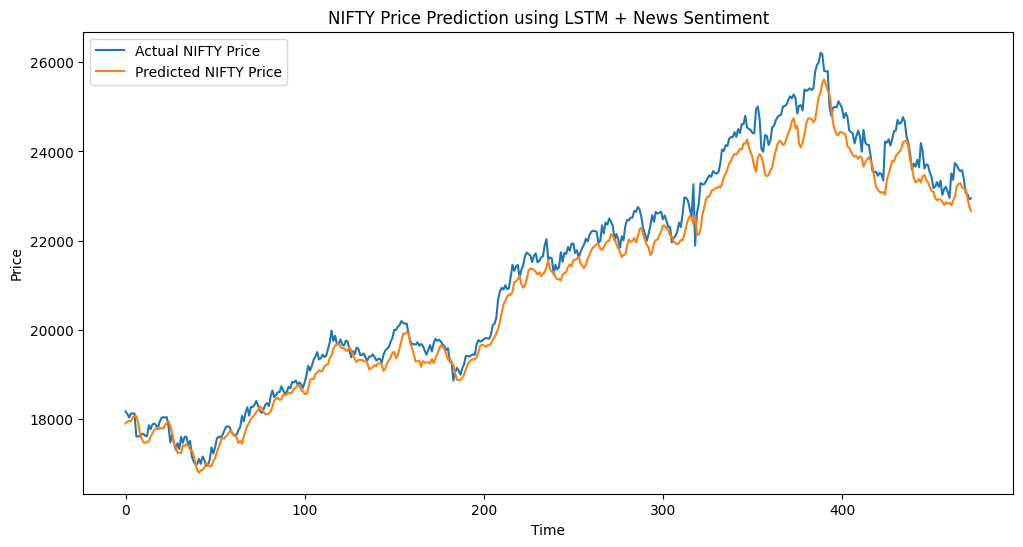

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Actual NIFTY Price')
plt.plot(y_pred_real, label='Predicted NIFTY Price')
plt.title('NIFTY Price Prediction using LSTM + News Sentiment')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
pip install vaderSentiment pandas scikit-learn tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 10.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# -------------------------------------------
# 1. Load and preprocess data
# -------------------------------------------
df = pd.read_csv('vader_nifty_cleaned_filled.csv')
df = df.drop(columns=['date'])
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')

# Scale both vader_score and closing price
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['vader_score', 'NIFTY_50_Close']])

# Create sequences
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, 1])
    return np.array(X), np.array(y)

SEQ_LEN = 10
X, y = create_sequences(scaled_data, SEQ_LEN)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Separate scaler for just price
scaler_price = MinMaxScaler()
price_scaled = scaler_price.fit_transform(df[['NIFTY_50_Close']])

# -------------------------------------------
# 2. Build and train model
# -------------------------------------------
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LEN, 2)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

# -------------------------------------------
# 3. Function: predict from user input news
# -------------------------------------------
def predict_nifty_from_news(news_text, recent_df):
    analyzer = SentimentIntensityAnalyzer()
    vader_score_today = analyzer.polarity_scores(news_text)['compound']

    last_price = recent_df['NIFTY_50_Close'].iloc[-1]
    temp_df = recent_df.copy()
    temp_df.loc[len(temp_df)] = [vader_score_today, last_price]

    scaled_input = scaler.transform(temp_df[['vader_score', 'NIFTY_50_Close']])
    X_input = scaled_input.reshape((1, 10, 2))

    pred_scaled = model.predict(X_input)
    predicted_price = scaler_price.inverse_transform(pred_scaled)[0][0]
    return predicted_price

# -------------------------------------------
# 4. Predict with user input
# -------------------------------------------
if __name__ == '__main__':
    user_news = input("\n📰 Enter today's news: ")
    recent_data = df[['vader_score', 'NIFTY_50_Close']].iloc[-9:].copy()
    predicted = predict_nifty_from_news(user_news, recent_data)
    print(f"\n📈 Predicted NIFTY Closing Price for Tomorrow: ₹{predicted:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0289 - val_loss: 0.0040
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7216e-04 - val_loss: 0.0018
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4010e-04 - val_loss: 7.4385e-04
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.7765e-04 - val_loss: 0.0013
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.5107e-04 - val_loss: 0.0015
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.5626e-04 - val_loss: 0.0011
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.4501e-04 - val_loss: 5.5869e-04
Epoch 8/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0947e-04 - val_loss: 3.9945e-04
Epoch 9/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5109e-04 - val_loss: 3.8436e-04
Epoch 10/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.3644e-04 - val_loss: 3.1978e-04
Epoch 11/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.5057e-04 

In [ ]:
import pickle

model.save("model.h5")

# Save scalers
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler_price, f)

with open("full_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save latest data
df[['vader_score', 'NIFTY_50_Close']].iloc[-9:].to_csv("data.csv", index=False)